# Exploratory notebook
## CDK2 protein

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%run ../modules/plotting_metrics.py

In [2]:
from memoization import cached


In [3]:
# Hold-out and Cross Validation

In [4]:
file_name = '../6_Machine_Learning_Models/df_DkSc_results_COCRYS_CSAR_DEKOIS_DUD.pkl'
X_merged_dksc = pd.read_pickle(file_name)
y_true_merged = X_merged_dksc['activity']
X_merged_dksc = X_merged_dksc.drop('activity', axis=1)
X_merged_dksc.shape

# Simplify the names
X = X_merged_dksc.values
y = y_true_merged.values

In [5]:
def plot_swarm_metrics(df_results, metric_name):
    sns.set(context='talk', style='whitegrid', font_scale=0.8)
    
    df_melted = pd.melt(df_results.loc[metric_name], var_name='method', value_name=metric_name)

    fig, ax = plt.subplots(figsize=(12,6))
    ax = sns.swarmplot(data=df_melted, x='method', y=metric_name,
                      size=6)
    sns.pointplot(data=df_melted, x='method', y=metric_name, dodge=True,
                  ci=95, ax=ax, join=False, color='black', capsize=0.4)
    ax.set(
           xlabel='VS Method')
    ax.set_title(f'ML vs CS results: {metric_name.replace("_", " ").upper()}', 
                 fontweight='bold', fontsize=18)


In [6]:
# Pandas styler
def _col_sig_p_values(val):
    color = 'red' if val < 0.05 else 'none'
    return 'color: %s' % color

## Classifiers and consensus Scorings
### ML Classifiers

In [7]:
from sklearn.dummy import DummyClassifier

hyparams = {'strategy': "stratified", "random_state": 42}
dclf = DummyClassifier(**hyparams)

In [8]:
from sklearn.neighbors import KNeighborsClassifier

hyparams ={'n_neighbors': 1, 'n_jobs': 4}
knn = KNeighborsClassifier(**hyparams)

In [9]:
from sklearn.linear_model import LogisticRegression 

hyparams = {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter':400}
lr = LogisticRegression(**hyparams)

In [10]:
from xgboost import XGBClassifier

hyparams ={'subsample': 0.5, 'n_estimators': 200, 
           'max_depth': 20, 'learning_rate': 0.05, 
           'gamma': 0.01, 'colsample_bytree': 0.5, 'alpha': 0.01}
xgb = XGBClassifier(**hyparams)

In [11]:
from sklearn.ensemble import RandomForestClassifier

hyparams = {'n_estimators': 100, 'min_samples_split': 10,
            'min_samples_leaf': 4, 
            'max_features': 'sqrt', 'max_depth': 10,
            'random_state': 42}
rf = RandomForestClassifier(**hyparams)

In [12]:
# ML Classifier
ml_classifiers = {
    'dclf': dclf,
    'knn': knn,
    'lr': lr,
    'xgb': xgb,
    'rf': rf
}

# update names
ml_classifiers = {f'ml_{name}': clf 
                for name, clf in ml_classifiers.items()}

### Consensus Scorings

In [13]:
%run ../6_Machine_Learning_Models/5_Helper_Consensus_Scoring.ipynb

cs_functions = {
    'MEAN': get_mean_score,
    'MAX': get_max_score,
    'MIN': get_min_score,
    'VOTE': get_vote_score,
    'RANK': get_rank_score 
}

# update names
cs_functions = {f'cs_{name}': func 
                for name, func in cs_functions.items()}

### Estimators dictionary

In [14]:
estimators = {**ml_classifiers, **cs_functions}

## Cross Validation

In [15]:
%run ./1_Helper_functions.ipynb

In [16]:
metrics=dict(roc_auc = {'metric_name': 'roc_auc'},
             nef_02 = {'metric_name': 'ef', 
                    'fraction': 0.02, 'method':'normalized'},
             nef_005 = {'metric_name': 'ef', 
                    'fraction': 0.005, 'method':'normalized'},
             nef_12_Ra = {'metric_name': 'ef', 
                    'fraction': 0.12, 'method':'normalized'}
            )

### 5 folds/reps

In [17]:
%%time
cv5 = k_cross_validation(estimators, X, y, 
                             metrics=metrics,
                             n_splits=5, random_state=42)

metric='roc_auc'
# Normality
display(multi_norm_test(cv5, metric=metric))
# Homocedasticity
display(multi_homovar_test(cv5, metric=metric))

cv5.loc[metric]

,ml_dclf,ml_knn,ml_lr,ml_xgb,ml_rf,cs_MEAN,cs_MAX,cs_MIN,cs_VOTE,cs_RANK
Normality,1,1,1,1,0,1,1,1,1,1


,statistic,p
Bartlett,4.718211,0.858148


CPU times: user 39.7 ms, sys: 4 ms, total: 43.7 ms
Wall time: 72.8 ms


,ml_dclf,ml_knn,ml_lr,ml_xgb,ml_rf,cs_MEAN,cs_MAX,cs_MIN,cs_VOTE,cs_RANK
0,0.49396,0.79516,0.88112,0.92751,0.87305,0.64234,0.64502,0.57160,0.62889,0.64197
1,0.50069,0.78846,0.86721,0.88513,0.81444,0.60090,0.62607,0.54079,0.60534,0.59789
2,0.50754,0.81858,0.91357,0.91118,0.86729,0.65380,0.67037,0.58591,0.64147,0.65064
3,0.49385,0.80517,0.89885,0.90776,0.86058,0.63146,0.63170,0.54574,0.63917,0.62874
4,0.51438,0.78136,0.91855,0.93413,0.87259,0.65086,0.64554,0.57859,0.62882,0.64914


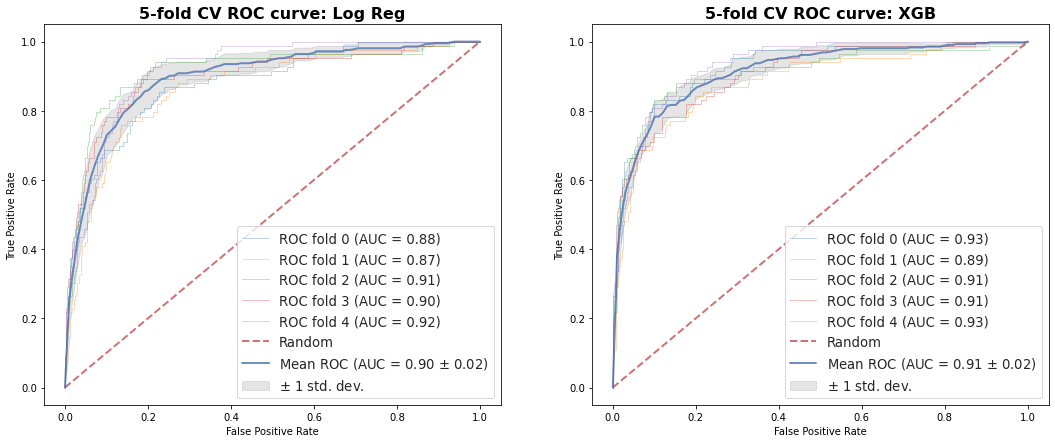

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(18, 7))
plot_roc_cv(lr, X, y, name='Log Reg', ax=ax[0], random_state=42)
plot_roc_cv(xgb, X, y, name='XGB', ax=ax[1], random_state=42)
plt.show()

### 15 folds/reps

,ml_dclf,ml_knn,ml_lr,ml_xgb,ml_rf,cs_MEAN,cs_MAX,cs_MIN,cs_VOTE,cs_RANK
Normality,0,1,1,0,1,1,1,1,1,1


,statistic,p
Bartlett,35.548471,0.000048


CPU times: user 8min 49s, sys: 46.7 s, total: 9min 36s
Wall time: 1min 51s


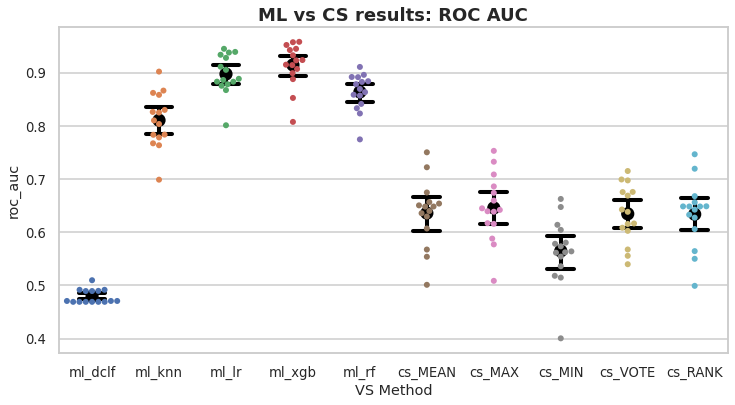

In [19]:
%%time
cv15 = k_cross_validation(estimators, X, y, 
                             metrics=metrics,
                             n_splits=15, random_state=42)

metric='roc_auc'
plot_swarm_metrics(cv15, metric_name=metric)
# Normality
display(multi_norm_test(cv15, metric=metric))
# Homocedasticity
display(multi_homovar_test(cv15, metric=metric))

## 5x2 CV

#### AUC-ROC

,ml_dclf,ml_knn,ml_lr,ml_xgb,ml_rf,cs_MEAN,cs_MAX,cs_MIN,cs_VOTE,cs_RANK
Normality,0,1,1,1,1,1,1,1,1,1


,statistic,p
Bartlett,16.862322,0.050916


CPU times: user 4min 19s, sys: 19.1 s, total: 4min 38s
Wall time: 1min 5s


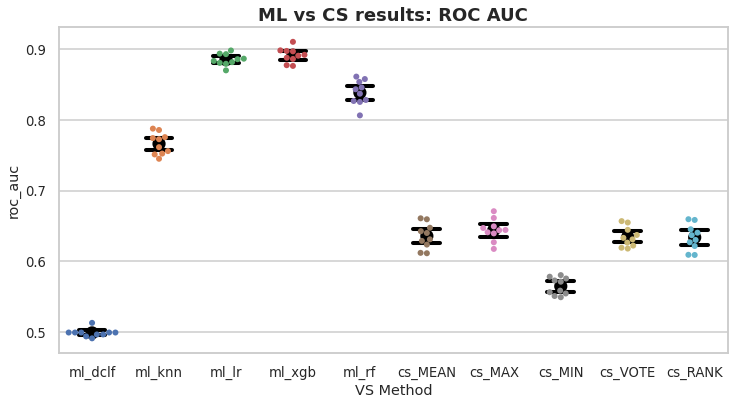

In [25]:
%%time
cv5x2 = nk_rep_cross_validation(estimators, X, y, metrics=metrics, 
                      n_splits=2, n_repeats=5, random_state=42)

metric='roc_auc'
plot_swarm_metrics(cv5x2, metric_name=metric)
# Normality
display(multi_norm_test(cv5x2))
# Homocedasticity
display(multi_homovar_test(cv5x2))

#### Enrichment Factor

,ml_dclf,ml_knn,ml_lr,ml_xgb,ml_rf,cs_MEAN,cs_MAX,cs_MIN,cs_VOTE,cs_RANK
Normality,0,1,1,1,1,1,1,1,1,1


,statistic,p
Bartlett,60.517488,1.065501e-09


CPU times: user 550 ms, sys: 116 ms, total: 666 ms
Wall time: 440 ms


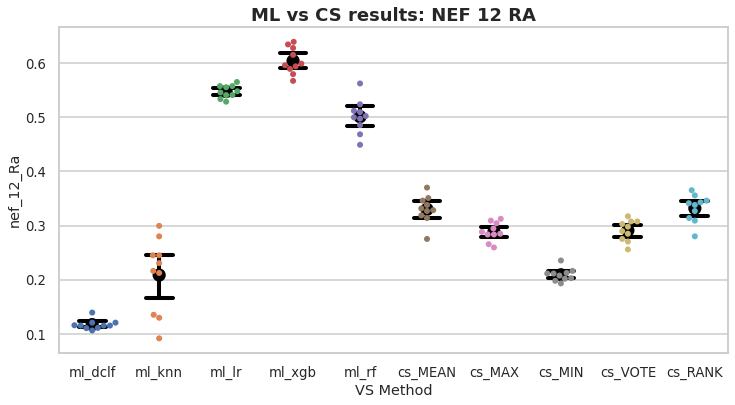

In [26]:
%%time
# cv5x2 = nk_rep_cross_validation(estimators, X, y, metrics=metrics, 
#                       n_splits=2, n_repeats=5, random_state=42)

metric='nef_12_Ra'
plot_swarm_metrics(cv5x2, metric_name=metric)
# Normality
display(multi_norm_test(cv5x2, metric=metric))
# Homocedasticity
display(multi_homovar_test(cv5x2, metric=metric))

## Hold-out validation

### 5 folds/reps

In [20]:
%%time
ho5 = n_hold_out_validation(estimators, X, y, metrics=metrics, 
                      n_reps=5, random_state=42)
metric='roc_auc'
# Normality
display(multi_norm_test(ho5, metric=metric))
# Homocedasticity
display(multi_homovar_test(ho5, metric=metric))

,ml_dclf,ml_knn,ml_lr,ml_xgb,ml_rf,cs_MEAN,cs_MAX,cs_MIN,cs_VOTE,cs_RANK
Normality,1,0,1,1,1,1,1,1,1,1


,statistic,p
Bartlett,8.067442,0.527364


CPU times: user 3min 2s, sys: 15.7 s, total: 3min 17s
Wall time: 42.1 s


### 15 folds/reps

/home/ricci/miniconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,ml_dclf,ml_knn,ml_lr,ml_xgb,ml_rf,cs_MEAN,cs_MAX,cs_MIN,cs_VOTE,cs_RANK
Normality,1,1,1,1,1,1,1,1,1,1


,statistic,p
Bartlett,33.108189,0.000128


CPU times: user 7min 59s, sys: 37.3 s, total: 8min 36s
Wall time: 1min 50s


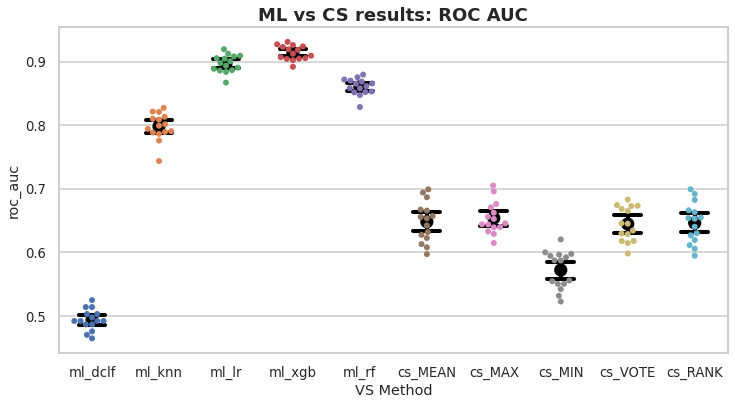

In [21]:
%%time
ho15 = n_hold_out_validation(estimators, X, y, metrics=metrics, 
                      n_reps=15, random_state=42)

metric='roc_auc'
plot_swarm_metrics(ho15, metric_name=metric)
# Normality
display(multi_norm_test(ho15, metric=metric))
# Homocedasticity
display(multi_homovar_test(ho15, metric=metric))

### 30 folds/reps

/home/ricci/miniconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,ml_dclf,ml_knn,ml_lr,ml_xgb,ml_rf,cs_MEAN,cs_MAX,cs_MIN,cs_VOTE,cs_RANK
Normality,1,1,1,1,1,1,1,1,1,1


,statistic,p
Bartlett,50.382274,9.128355e-08


CPU times: user 15min 14s, sys: 1min 19s, total: 16min 34s
Wall time: 3min 29s


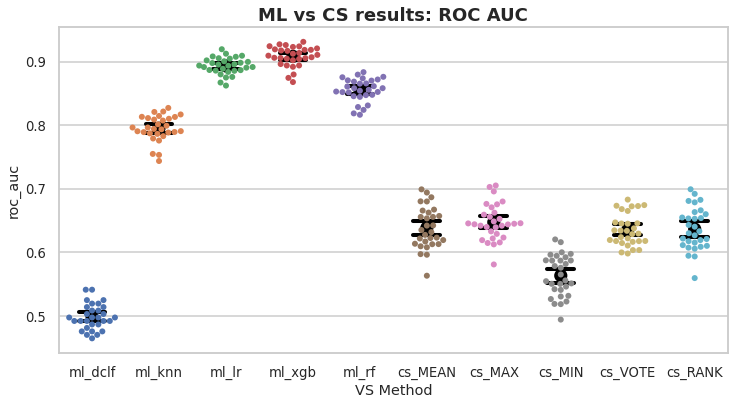

In [700]:
%%time
ho30 = n_hold_out_validation(estimators, X, y, metrics=metrics, 
                      n_reps=30, random_state=42)

metric='roc_auc'
plot_swarm_metrics(ho30, metric_name=metric)
# Normality
display(multi_norm_test(ho30, metric=metric))
# Homocedasticity
display(multi_homovar_test(ho30, metric=metric))

#### R version example

In [701]:
%load_ext rpy2.ipython

ho30_roc_auc = ho30.loc['roc_auc', :]

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [702]:
%%R -i  ho30_roc_auc
library(dplyr)
library(tidyr)
library(broom)

df = ho15_roc_auc
bartlett <- df %>%
    pivot_longer(cols=everything(), names_to='Method', 
                 values_to='score') %>%
    bartlett.test(formula=score~Method, data=.)

shapiro <- df %>%
    pivot_longer(cols=everything(), names_to='Method', 
                 values_to='score') %>%
    group_by(Method) %>%
    do(tidy(shapiro.test(.$score))) %>%
    mutate(H0 = case_when(p.value < 0.05 ~ 'Rejected', TRUE ~ 'Accepted'))

print(shapiro)
print(bartlett)

# A tibble: 9 x 5
# Groups:   Method [9]
  Method  statistic p.value method                      H0      
  <chr>       <dbl>   <dbl> <chr>                       <chr>   
1 cs_MAX      0.948   0.494 Shapiro-Wilk normality test Accepted
2 cs_MEAN     0.966   0.796 Shapiro-Wilk normality test Accepted
3 cs_MIN      0.921   0.200 Shapiro-Wilk normality test Accepted
4 cs_RANK     0.972   0.881 Shapiro-Wilk normality test Accepted
5 cs_VOTE     0.930   0.270 Shapiro-Wilk normality test Accepted
6 ml_knn      0.927   0.244 Shapiro-Wilk normality test Accepted
7 ml_lr       0.973   0.896 Shapiro-Wilk normality test Accepted
8 ml_rf       0.950   0.524 Shapiro-Wilk normality test Accepted
9 ml_xgb      0.953   0.571 Shapiro-Wilk normality test Accepted

	Bartlett test of homogeneity of variances

data:  score by Method
Bartlett's K-squared = 30.345, df = 8, p-value = 0.0001836



#### Enrichment Factor

,ml_dclf,ml_knn,ml_lr,ml_xgb,ml_rf,cs_MEAN,cs_MAX,cs_MIN,cs_VOTE,cs_RANK
Normality,1,0,1,1,1,1,1,1,1,1


,statistic,p
Bartlett,4.186318,0.898727


CPU times: user 558 ms, sys: 104 ms, total: 662 ms
Wall time: 434 ms


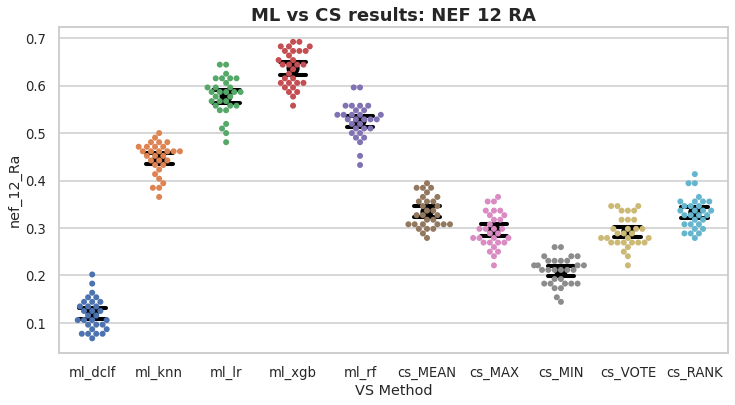

In [703]:
%%time
# ho15 = n_hold_out_validation(estimators, X, y, metrics=metrics, 
#                       n_reps=15, random_state=42)

metric='nef_12_Ra'
plot_swarm_metrics(ho30, metric_name=metric)
# Normality
display(multi_norm_test(ho30, metric=metric))
# Homocedasticity
display(multi_homovar_test(ho30, metric=metric))

## Multiple samples comparison

- one-way ANOVA with repeated measures
- Friedman's ANOVA
- Cochran's Q test
- Binomial $\chi^2$ with Bonferroni correction

### one-way ANOVA with repeated measures

$H_0$: $\mu_1 = \mu_2 = ... = \mu_m$   
$H_a$: $\mu_i \neq \mu_j$, for at least one pair $i,j$ of the methods.

##### post hoc Tucket HSD
$H_0$: $\mu_i = \mu_j, \forall i \neq j$   
$H_a$: $\mu_i \neq \mu_j,  \forall i \neq j$


#### Python

In [704]:
import statsmodels
from statsmodels.stats.anova import AnovaRM
from statsmodels import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import f_oneway

In [706]:
df = ho30.loc['roc_auc'].drop('ml_dclf', axis=1)

n, m = df.shape

df2 =df.copy()
df2['rep'] = np.arange(1, n + 1)
f = pd.melt(df2, id_vars='rep', var_name='clf', value_name='score')

print(AnovaRM(data=f, depvar='score', subject='rep', within=['clf'], aggregate_func='mean').fit())

print(pairwise_tukeyhsd(endog=f['score'], groups=f['clf'], alpha=0.25))

               Anova
     F Value  Num DF  Den DF  Pr > F
------------------------------------
clf 1692.8141 8.0000 232.0000 0.0000

 Multiple Comparison of Means - Tukey HSD, FWER=0.25  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
 cs_MAX cs_MEAN   -0.009    0.9 -0.0251  0.0072  False
 cs_MAX  cs_MIN   -0.084  0.001 -0.1001 -0.0679   True
 cs_MAX cs_RANK  -0.0108 0.7397  -0.027  0.0053  False
 cs_MAX cs_VOTE  -0.0122  0.615 -0.0283  0.0039  False
 cs_MAX  ml_knn   0.1477  0.001  0.1316  0.1639   True
 cs_MAX   ml_lr   0.2457  0.001  0.2295  0.2618   True
 cs_MAX   ml_rf   0.2079  0.001  0.1918   0.224   True
 cs_MAX  ml_xgb   0.2607  0.001  0.2446  0.2768   True
cs_MEAN  cs_MIN  -0.0751  0.001 -0.0912 -0.0589   True
cs_MEAN cs_RANK  -0.0019    0.9  -0.018  0.0142  False
cs_MEAN cs_VOTE  -0.0032    0.9 -0.0194  0.0129  False
cs_MEAN  ml_knn   0.1567  0.001  0.1406  0.1728   True
cs_MEAN   ml_lr   0.2546  0.001  0.2385  0

##### Using a Regression Model

In [707]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

lm = ols('score ~ C(clf) + C(rep)', data=f).fit()
# print(lm.summary())
table = sm.stats.anova_lm(lm, typ=2) 
table

,sum_sq,df,F,PR(>F)
C(clf),4.168209,8.0,1692.814068,4.778438e-201
C(rep),0.094812,29.0,10.622253,1.100511e-28
Residual,0.071407,232.0,NaN,NaN


##### Pinguoin package

In [708]:
import pingouin as pg

In [709]:
pg.rm_anova(data=f, dv='score', within='clf', subject='rep', detailed=True)

,Source,SS,DF,MS,F,p-unc,np2,eps
0,clf,4.168209,8,0.521026,1692.814068,4.778438e-201,0.983157,0.238966
1,Error,0.071407,232,0.000308,NaN,NaN,NaN,NaN


In [710]:
# FDR-corrected post hocs with Hedges'g effect size
posthoc = pg.pairwise_ttests(data=f, dv='score', within='clf', subject='rep',
                             parametric=True, padjust='fdr_bh', effsize='hedges')

# Pretty printing of table
# pg.print_table(posthoc, floatfmt='.3f')

#### R

In [712]:
# Using the same dataset, dropping the dummy classifier
ho30_roc_auc = ho30.loc['roc_auc'].drop('ml_dclf', axis=1)

In [714]:
%%R -i ho30_roc_auc

# One way anova using R
library(dplyr)
library(tidyr)
library(emmeans)

df = ho15_roc_auc
df_melt <- df %>%
    mutate(rep = factor(1:15)) %>%
    pivot_longer(cols=c(everything(), -rep), names_to='Method', 
                 values_to='score')

anova <- aov(score ~ Method + factor(rep), data=df_melt)
print(summary(anova))

# print(pairs(emmeans(anova, 'Method'), infer=c(T,T), adjust='fdr', reverse=T))

             Df Sum Sq Mean Sq F value   Pr(>F)    
Method        8 2.0168 0.25210  943.38  < 2e-16 ***
factor(rep)  14 0.0416 0.00297   11.12 1.66e-15 ***
Residuals   112 0.0299 0.00027                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### Non-parametric: Friedman's ANOVA for repeated measures

$H_0$: $R_i = R_j, \forall i \neq j$


#### Python

In [715]:
from scipy.stats import friedmanchisquare

friedmanchisquare(*df.values.T)

FriedmanchisquareResult(statistic=222.19555555555553, pvalue=1.3230985905584587e-43)

In [716]:
from pingouin import friedman

friedman(data=f, dv='score', within='clf', subject='rep')

,Source,ddof1,Q,p-unc
Friedman,clf,8,222.195556,1.323099e-43


#### R
source: https://cran.r-project.org/web/packages/scmamp/vignettes/Statistical_assessment_of_the_differences.html

In [718]:
%%R -i ho30_roc_auc -o odf
library("scmamp")

df = ho30_roc_auc
print(friedmanTest(df))
print(imanDavenportTest(df))


	Friedman's rank sum test

data:  df
Friedman's chi-squared = 222.2, df = 8, p-value < 2.2e-16


	Iman Davenport's correction of Friedman's rank sum test

data:  df
Corrected Friedman's chi-squared = 361.91, df1 = 8, df2 = 232, p-value
< 2.2e-16



#### Manual implementation 

$$\chi^2_F = \frac{12N}{k(k+1)}\left[\sum_j^k R^2_j - \frac{k(k-1)^2}{4}\right]$$

where

$$R_j = \sum_i \frac{1}{N}r_i^j$$

and $r_i^j$ the rank of the $j$-th of $k$ algorithms on the $i$-th of $N$ data sets.
The the null-hypothesis states that all the algorithms are equivalent and so their ranks $R_j$ should be equal:
 


In [719]:
%run Friedman_and_Nemenyi_test.ipynb

In [720]:
friedmanTest(df)

,chi^2,dof,p_value
Friedman Test,222.195556,8,1.323099e-43


**Iman and Davenport** (1980) showed that Friedman’s χ2
F is undesirably conservative and derived a better statistic

$$F_F = \frac{(N-1)\chi_F^2}{N(k-1) - \chi_F^2}$$

which is distributed according to the F-distribution with k−1 and (k−1)(N−1) degrees offreedom.

In [721]:
friedman_imanDavenportTest(df)

,F,dof1,dof2,p_value
Friedman Test,361.91363,8,232,1.971161e-126


### post hocs

#### Wilcoxon

In [722]:
import scikit_posthocs as sp

sp.posthoc_conover(f, val_col='score', group_col='clf').style.applymap(_col_sig_p_values)

,cs_MAX,cs_MEAN,cs_MIN,cs_RANK,cs_VOTE,ml_knn,ml_lr,ml_rf,ml_xgb
cs_MAX,1.000000,0.096345,0.000000,0.040243,0.032484,0.000000,0.000000,0.000000,0.000000
cs_MEAN,0.096345,1.000000,0.000000,0.694882,0.630903,0.000000,0.000000,0.000000,0.000000
cs_MIN,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cs_RANK,0.040243,0.694882,0.000000,1.000000,0.929665,0.000000,0.000000,0.000000,0.000000
cs_VOTE,0.032484,0.630903,0.000000,0.929665,1.000000,0.000000,0.000000,0.000000,0.000000
ml_knn,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000008,0.000000
ml_lr,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000001,0.009279
ml_rf,0.000000,0.000000,0.000000,0.000000,0.000000,0.000008,0.000001,1.000000,0.000000
ml_xgb,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009279,0.000000,1.000000


#### Nemenyi test

##### Critical Difference

Two methods are significantly different if if the corresponding average ranks differ by at least the critical difference:

$$CD = q_{\alpha} \sqrt\frac{k(k+1)}{6N}$$



In [723]:
alpha, (N, k) = 0.05, df.shape
CD = get_critical_values_nemenyi(alpha, k)
print('Critical Difference:', CD)
display(pairwise_nemenyi(df)[1].style.applymap(_col_H0_rejected))

Critical Difference: 3.101737417612634


,cs_MAX,cs_MEAN,cs_MIN,cs_RANK,cs_VOTE,ml_knn,ml_lr,ml_rf,ml_xgb
cs_MAX,False,False,True,False,False,False,True,True,True
cs_MEAN,False,False,True,False,False,False,True,True,True
cs_MIN,True,True,False,False,False,True,True,True,True
cs_RANK,False,False,False,False,False,True,True,True,True
cs_VOTE,False,False,False,False,False,True,True,True,True
ml_knn,False,False,True,True,True,False,False,False,True
ml_lr,True,True,True,True,True,False,False,False,False
ml_rf,True,True,True,True,True,False,False,False,False
ml_xgb,True,True,True,True,True,True,False,False,False


##### Statistical significance

$$Q = |R_i - R_j| \Bigg/ \sqrt\frac{k(k+1)}{6N}$$

the probability distribution of **_Q_** can be approximated by that of a chi-squared distribution. In this case the p-value is given by
 $P(\chi^2_{k-1} \leq Q)$.

In [736]:
display(pairwise_nemenyi(df)[0].style.applymap(_col_sig_p_values))

,cs_MAX,cs_MEAN,cs_MIN,cs_RANK,cs_VOTE,ml_knn,ml_lr,ml_rf,ml_xgb
cs_MAX,1.000000,0.900000,0.001000,0.720873,0.900000,0.152261,0.001000,0.001116,0.001000
cs_MEAN,0.900000,1.000000,0.004263,0.900000,0.900000,0.031455,0.001000,0.001000,0.001000
cs_MIN,0.001000,0.004263,1.000000,0.152261,0.031455,0.001000,0.001000,0.001000,0.001000
cs_RANK,0.720873,0.900000,0.152261,1.000000,0.900000,0.001000,0.001000,0.001000,0.001000
cs_VOTE,0.900000,0.900000,0.031455,0.900000,1.000000,0.004263,0.001000,0.001000,0.001000
ml_knn,0.152261,0.031455,0.001000,0.001000,0.004263,1.000000,0.083690,0.863904,0.001362
ml_lr,0.001000,0.001000,0.001000,0.001000,0.001000,0.083690,1.000000,0.863904,0.900000
ml_rf,0.001116,0.001000,0.001000,0.001000,0.001000,0.863904,0.863904,1.000000,0.170364
ml_xgb,0.001000,0.001000,0.001000,0.001000,0.001000,0.001362,0.900000,0.170364,1.000000


In [724]:
# https://github.com/maximtrp/scikit-posthocs/blob/master/scikit_posthocs/_posthocs.py
sp.posthoc_nemenyi_friedman(f, y_col='score', group_col='clf', 
                            block_col='rep', melted=True, sort=True).style.applymap(_col_sig_p_values)

,cs_MAX,cs_MEAN,cs_MIN,cs_RANK,cs_VOTE,ml_knn,ml_lr,ml_rf,ml_xgb
cs_MAX,1.000000,0.900000,0.001000,0.720873,0.900000,0.152261,0.001000,0.001116,0.001000
cs_MEAN,0.900000,1.000000,0.004263,0.900000,0.900000,0.031455,0.001000,0.001000,0.001000
cs_MIN,0.001000,0.004263,1.000000,0.152261,0.031455,0.001000,0.001000,0.001000,0.001000
cs_RANK,0.720873,0.900000,0.152261,1.000000,0.900000,0.001000,0.001000,0.001000,0.001000
cs_VOTE,0.900000,0.900000,0.031455,0.900000,1.000000,0.004263,0.001000,0.001000,0.001000
ml_knn,0.152261,0.031455,0.001000,0.001000,0.004263,1.000000,0.083690,0.863904,0.001362
ml_lr,0.001000,0.001000,0.001000,0.001000,0.001000,0.083690,1.000000,0.863904,0.900000
ml_rf,0.001116,0.001000,0.001000,0.001000,0.001000,0.863904,0.863904,1.000000,0.170364
ml_xgb,0.001000,0.001000,0.001000,0.001000,0.001000,0.001362,0.900000,0.170364,1.000000


#### R

In [725]:
# Using the same dataset, dropping the dummy classifier
ho30_roc_auc = ho30.loc['roc_auc'].drop('ml_dclf', axis=1)

The p-values are sightly different because the degrees of freedom used when the **Studentized Range Distribution** is computed.
The version of the PMCMR package used here uses a dof value of `1000000` instead of `inf`. [Link to the source code](https://github.com/cran/PMCMR/blob/master/R/posthoc.friedman.nemenyi.test.R).


In [728]:
%%R -i ho30_roc_auc

# One way anova using R
library(dplyr)
library(rstatix)
library(PMCMR)

df = ho30_roc_auc
df_melt <- df %>%
    mutate(rep = factor(1:30)) %>%
    pivot_longer(cols=c(everything(), -rep), names_to='Method', 
                 values_to='score')

print(packageVersion("PMCMR"))
print(friedman.test(score ~ Method | rep, df_melt))

pwc <- df_melt %>%
  wilcox_test(score ~ Method, paired = TRUE, p.adjust.method = "bonferroni")
pwc


posthoc.friedman.nemenyi.test(formula=score ~ Method | rep, data=df_melt)

[1] ‘4.3’

	Friedman rank sum test

data:  score and Method and rep
Friedman chi-squared = 222.2, df = 8, p-value < 2.2e-16


	Pairwise comparisons using Nemenyi multiple comparison test	
             with q approximation for unreplicated blocked data 

data:  score and Method and rep 

        cs_MAX  cs_MEAN cs_MIN  cs_RANK cs_VOTE ml_knn ml_lr  ml_rf 
cs_MEAN 0.9998  -       -       -       -       -      -      -     
cs_MIN  0.0004  0.0043  -       -       -       -      -      -     
cs_RANK 0.7486  0.9696  0.1523  -       -       -      -      -     
cs_VOTE 0.9696  0.9998  0.0314  0.9998  -       -      -      -     
ml_knn  0.1523  0.0314  5.5e-11 0.0004  0.0043  -      -      -     
ml_lr   7.3e-07 2.4e-08 7.1e-14 9.9e-12 5.7e-10 0.0833 -      -     
ml_rf   0.0011  8.5e-05 8.4e-14 1.8e-07 4.6e-06 0.8734 0.8734 -     
ml_xgb  4.1e-10 7.0e-12 2.6e-14 8.8e-14 2.1e-13 0.0014 0.9611 0.1701

P value adjustment method: none 


### poshocs Visualization

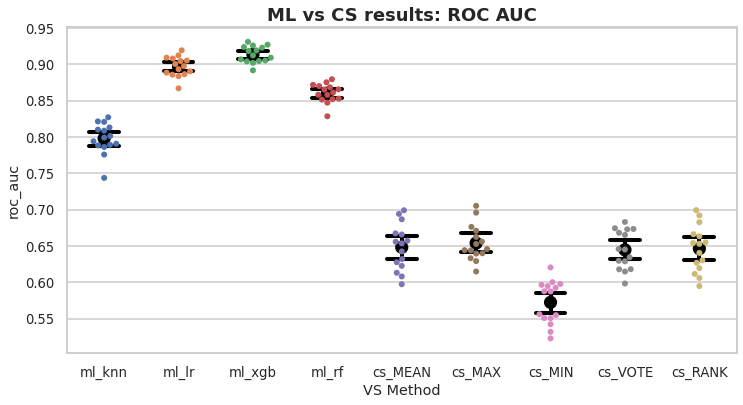

In [734]:
metric='roc_auc'
plot_swarm_metrics(ho15.drop('ml_dclf', axis=1), metric_name=metric)

Critical Difference: 3.10173


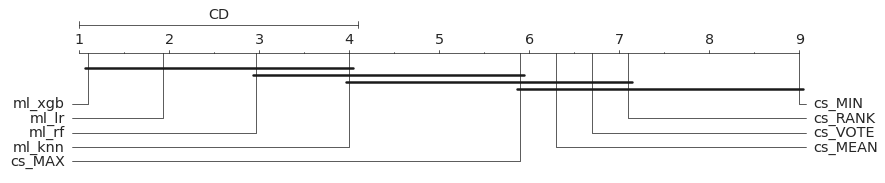

In [733]:
import Orange
import matplotlib.pyplot as plt

names = df.columns
avranks =  get_R(df)
cd = Orange.evaluation.compute_CD(avranks, 15, alpha='0.05') #tested on 30 datasets
print('Critical Difference:', cd)
ax = Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=12, textspace=1.)
plt.show()

         cs_MAX  cs_MEAN  cs_MIN  cs_RANK  cs_VOTE  ml_knn  ml_lr  ml_rf  \
cs_MAX     -1.0      0.0     1.0      0.0      0.0     0.0    1.0    2.0   
cs_MEAN     0.0     -1.0     2.0      0.0      0.0     3.0    1.0    1.0   
cs_MIN      1.0      2.0    -1.0      0.0      3.0     1.0    1.0    1.0   
cs_RANK     0.0      0.0     0.0     -1.0      0.0     1.0    1.0    1.0   
cs_VOTE     0.0      0.0     3.0      0.0     -1.0     2.0    1.0    1.0   
ml_knn      0.0      3.0     1.0      1.0      2.0    -1.0    0.0    0.0   
ml_lr       1.0      1.0     1.0      1.0      1.0     0.0   -1.0    0.0   
ml_rf       2.0      1.0     1.0      1.0      1.0     0.0    0.0   -1.0   
ml_xgb      1.0      1.0     1.0      1.0      1.0     2.0    0.0    0.0   

         ml_xgb  
cs_MAX      1.0  
cs_MEAN     1.0  
cs_MIN      1.0  
cs_RANK     1.0  
cs_VOTE     1.0  
ml_knn      2.0  
ml_lr       0.0  
ml_rf       0.0  
ml_xgb     -1.0  
-----------


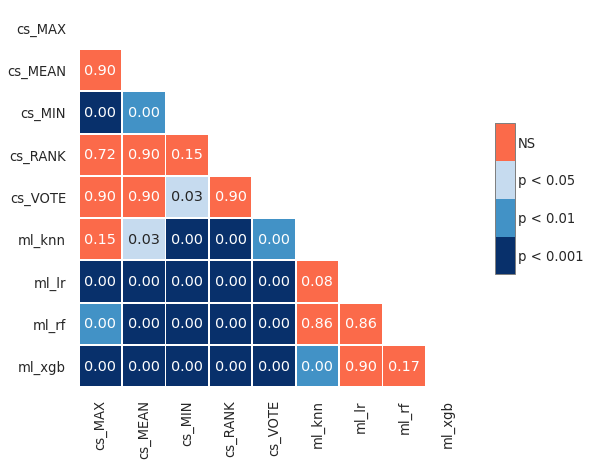

In [738]:
cmap = ['1', '#fb6a4a',  '#08306b',  '#4292c6', '#c6dbef']
mask = np.zeros_like(p_values_nemenyi, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

p_values_nemenyi = pairwise_nemenyi(df)[0]

ax, _ = sp.sign_plot(p_values_nemenyi - 0.000000001, clip_on= False, cmap=cmap,
                 linewidths= 1, linecolor= 'white', mask=mask,
                 annot=p_values_nemenyi, fmt='.2f')
plt.show()

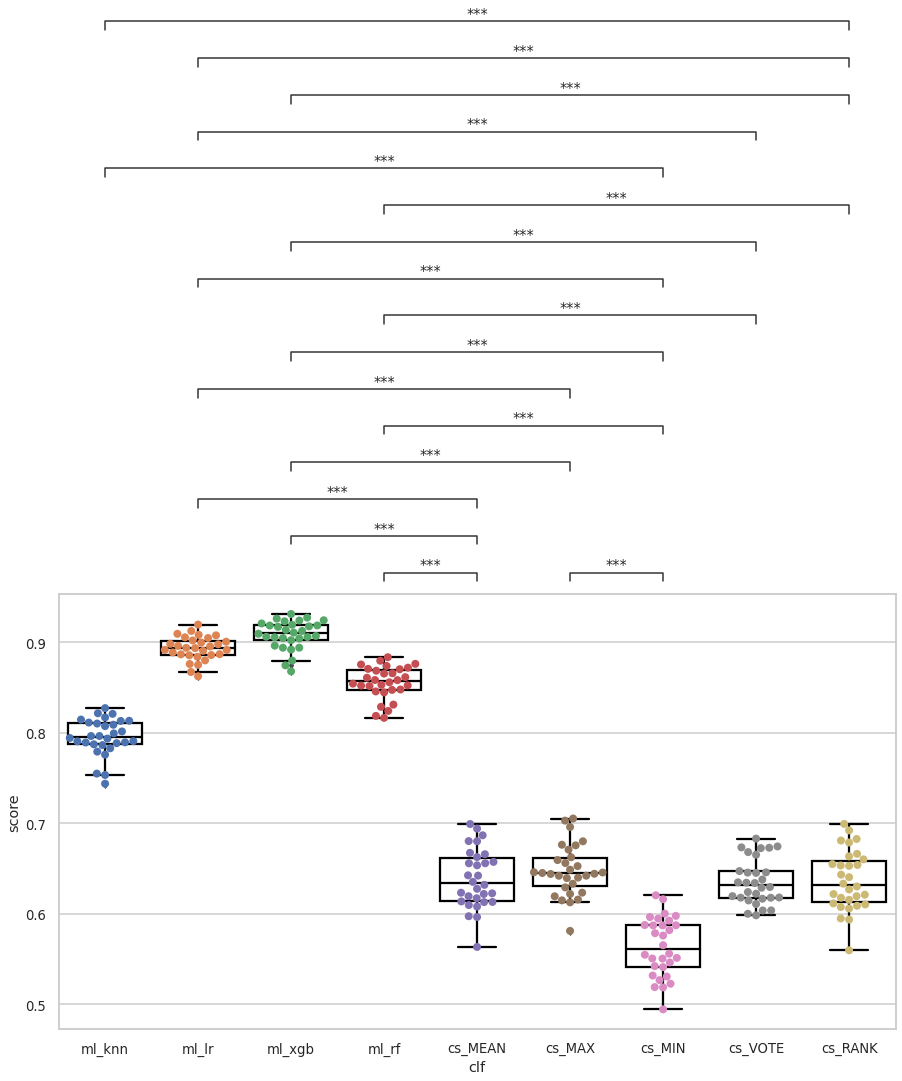

In [739]:
from statannot import add_stat_annotation


box_pairs = [*it.combinations(df.columns, 2)]
sig_p_values = []
sig_box_pairs = []
for pair in box_pairs:
#     print(pair)
    p = p_values_nemenyi.loc[pair]
    if p <= 0.001:
        sig_p_values.append(p)
        sig_box_pairs.append(pair)
    
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.boxplot(data=f, x='clf', y='score')
ax = sns.swarmplot(data=f, x='clf', y='score', size=8)
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(6*i,6*(i+1)):
         ax.lines[j].set_color('black')


test_results = add_stat_annotation(ax, data=f, x='clf', y='score',
                                   box_pairs=sig_box_pairs,
                                   perform_stat_test=False, pvalues=sig_p_values, #test_short_name=test_short_name,
                                   text_format='star', verbose=0, loc='outside')